# Test data vs model match, without emulator

/n/home12/cgarciaquintero/.conda/envs/cosmodesi/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


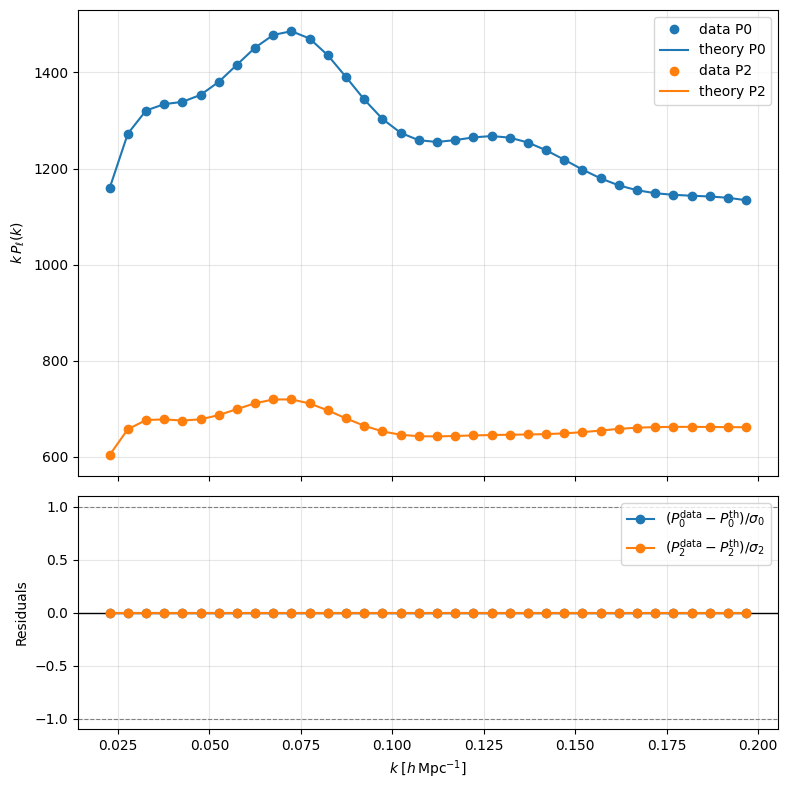

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI
from desilike.emulators import EmulatedCalculator
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable

# -----------------------------
# USER SETTINGS
# -----------------------------
workdir = Path("/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike")
emu_dir = Path("/n/netscratch/eisenstein_lab/Lab/cristhian/desilike/Emulators")

file_tag   = "BGS"
fid_model  = "LCDM"
MG_model   = "HDKI"
mg_variant = "mu_OmDE"
ells       = (0, 2)
freedom    = "max"

beyond_eds     = True
redshift_bins  = False
scale_bins     = False
kc             = 0.01
scale_bins_method = "traditional"

# -----------------------------
# Load data
# -----------------------------
k = np.loadtxt(workdir / f"{file_tag}_{fid_model}_k.txt")
Pvec = np.loadtxt(workdir / f"{file_tag}_{fid_model}_P0P2P4.txt")

N = len(k)
P0, P2, P4 = Pvec[:N], Pvec[N:2*N], Pvec[2*N:3*N]

# -----------------------------
# Load covariance and extract errors
# -----------------------------
cov_path = workdir / f"{file_tag}_{fid_model}_cov.txt"
Cov = np.loadtxt(cov_path)

# diagonal errors:
sigma0 = np.sqrt(np.diag(Cov)[:N])
sigma2 = np.sqrt(np.diag(Cov)[N:2*N])

# -----------------------------
# Rebuild the theory + emulator
# -----------------------------
z_eff = 0.295

h = 0.6736
ombh2 = 0.02237
omch2 = 0.12
omnuh2 = 0.06 / 93.14
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
As = 2.083e-09
#As = 2.2e-09
ns = 0.9649
Neff=3.046
mu0=0.

# Nuisance parameters
b1 = 1.5
b2 = -0.5247206065
bs2 = 0.0
b3nl = 0.0
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0 
ctilde, alpha0shot, alpha2shot = 0.0, 0.08, -2.0
pshotp = 10000

cosmo = Cosmoprimo(engine='isitgr', MG_parameterization="muSigma",
                   N_eff=Neff, m_ncdm=[0.06])
cosmo.init.params['mu0'] = dict(prior=dict(dist='uniform', limits=[-5., 5.]))
cosmo.init.params['mu0'].update(value=mu0)

cosmo_params = {
    "h": h,
    "omega_b": ombh2,
    "omega_cdm": omch2,
    "logA": np.log(1e10*As),
    "n_s": ns,
}
for name, value in cosmo_params.items():
    cosmo.init.params[name].update(value=value)

template = DirectPowerSpectrumTemplate(z=z_eff, fiducial=DESI(), cosmo=cosmo)

theory = fkptTracerPowerSpectrumMultipoles()
theory.init.update(
    freedom=freedom,
    prior_basis="standard",
    tracer=file_tag,
    template=template,
    k=k,
    ells=list(ells),
    model=MG_model,
    mg_variant=mg_variant,
    beyond_eds=beyond_eds,
    rescale_PS=False,
    shotnoise=pshotp
)

# Fix nuisance params
for name, val in zip(
    ["b1","b2","bs2","b3nl","alpha0","alpha2","alpha4","ctilde","alpha0shot","alpha2shot"],
    [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alpha0shot, alpha2shot]
):
    theory.init.params[name].update(fixed=True, value=val)

# -----------------------------
# Evaluate theory
# -----------------------------
logA = np.log(10**10*As)
P_theory = np.asarray(theory())

if P_theory.ndim == 1:
    P0_th, P2_th = P_theory[:N], P_theory[N:2*N]
elif P_theory.ndim == 2:
    P0_th, P2_th = P_theory[0], P_theory[1]

# -----------------------------
# Compute normalized residuals
# -----------------------------
resid0 = (P0 - P0_th) / sigma0
resid2 = (P2 - P2_th) / sigma2

# -----------------------------
# Plot: top (Pℓ), bottom (residuals)
# -----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                               gridspec_kw={"height_ratios": [2, 1]})

# --- TOP PANEL ---
ax1.plot(k, k * P0, 'o', color='C0', label='data P0')
ax1.plot(k, k * P0_th, '-', color='C0', label='theory P0')

ax1.plot(k, k * P2, 'o', color='C1', label='data P2')
ax1.plot(k, k * P2_th, '-', color='C1', label='theory P2')

ax1.set_ylabel(r"$k\,P_\ell(k)$")
ax1.legend()
ax1.grid(alpha=0.3)

# --- BOTTOM PANEL ---
ax2.axhline(0, color='k', lw=1)
ax2.axhline(1, color='gray', ls='--', lw=0.8)
ax2.axhline(-1, color='gray', ls='--', lw=0.8)

ax2.plot(k, resid0, 'o-', color='C0', label=r'$(P_0^{\rm data}-P_0^{\rm th})/\sigma_0$')
ax2.plot(k, resid2, 'o-', color='C1', label=r'$(P_2^{\rm data}-P_2^{\rm th})/\sigma_2$')

ax2.set_xlabel(r"$k \; [h\,\mathrm{Mpc}^{-1}]$")
ax2.set_ylabel("Residuals")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Test with emulator

Loading: /n/netscratch/eisenstein_lab/Lab/cristhian/desilike/Emulators/emu-fs_fkpt_isitgr_mu0_BGS_k0.020-0.199_l02.npy
'beta_1' not found. Setting beta_1 = 0.0.
'lambda_1' not found. Setting lambda_1 = 0.0.
'exp_s' not found. Setting exp_s = 0.0.


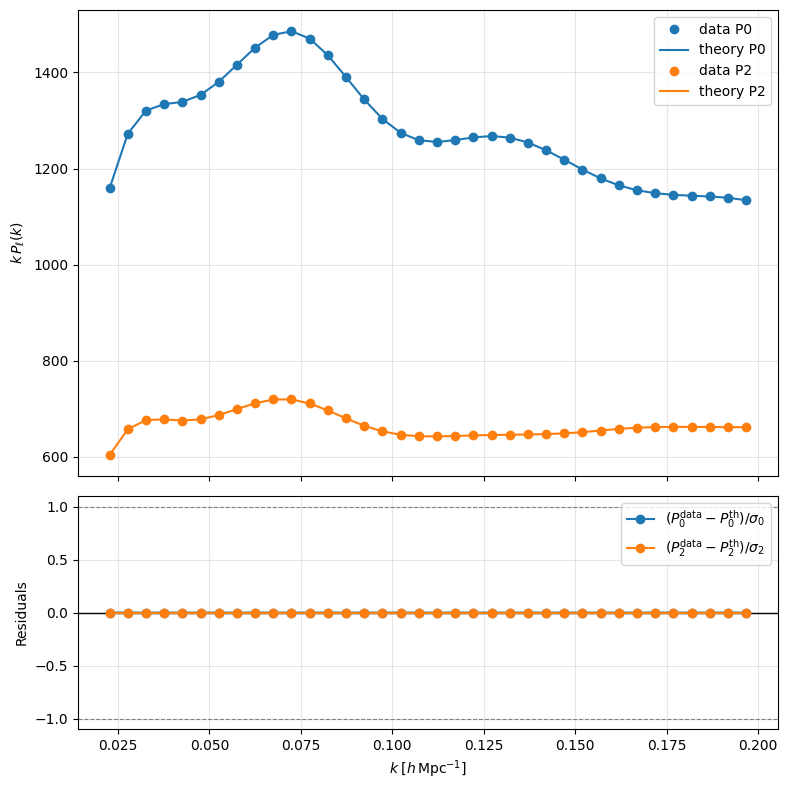

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI
from desilike.emulators import EmulatedCalculator
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable

# -----------------------------
# USER SETTINGS
# -----------------------------
workdir = Path("/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike")
emu_dir = Path("/n/netscratch/eisenstein_lab/Lab/cristhian/desilike/Emulators")

file_tag   = "BGS"
fid_model  = "LCDM"
MG_model   = "HDKI"
mg_variant = "BZ"
ells       = (0, 2)
freedom    = "max"

beyond_eds     = True
redshift_bins  = False
scale_bins     = False
kc             = 0.01
scale_bins_method = "traditional"

# -----------------------------
# Load data
# -----------------------------
k = np.loadtxt(workdir / f"{file_tag}_{fid_model}_k.txt")
Pvec = np.loadtxt(workdir / f"{file_tag}_{fid_model}_P0P2P4.txt")

N = len(k)
P0, P2, P4 = Pvec[:N], Pvec[N:2*N], Pvec[2*N:3*N]

# -----------------------------
# Load covariance and extract errors
# -----------------------------
cov_path = workdir / f"{file_tag}_{fid_model}_cov.txt"
Cov = np.loadtxt(cov_path)

# diagonal errors:
sigma0 = np.sqrt(np.diag(Cov)[:N])
sigma2 = np.sqrt(np.diag(Cov)[N:2*N])

# -----------------------------
# Rebuild the theory + emulator
# -----------------------------
z_eff = 0.295

h = 0.6736
ombh2 = 0.02237
omch2 = 0.12
omnuh2 = 0.06 / 93.14
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
As = 2.083e-09
#As = 2.2e-09
ns = 0.9649
Neff=3.046
mu0=0.

# Nuisance parameters
b1 = 1.5
b2 = -0.5247206065
bs2 = 0.0
b3nl = 0.0
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0 
ctilde, alpha0shot, alpha2shot = 0.0, 0.08, -2.0
pshotp = 10000

cosmo = Cosmoprimo(engine='isitgr', MG_parameterization="muSigma",
                   N_eff=Neff, m_ncdm=[0.06])
cosmo.init.params['mu0'] = dict(prior=dict(dist='uniform', limits=[-5., 5.]))
cosmo.init.params['mu0'].update(value=mu0)

cosmo_params = {
    "h": h,
    "omega_b": ombh2,
    "omega_cdm": omch2,
    "logA": np.log(1e10*As),
    "n_s": ns,
}
for name, value in cosmo_params.items():
    cosmo.init.params[name].update(value=value)

template = DirectPowerSpectrumTemplate(z=z_eff, fiducial=DESI(), cosmo=cosmo)

theory = fkptTracerPowerSpectrumMultipoles()
theory.init.update(
    freedom=freedom,
    prior_basis="standard",
    tracer=file_tag,
    template=template,
    k=k,
    ells=list(ells),
    model=MG_model,
    mg_variant=mg_variant,
    beyond_eds=beyond_eds,
    rescale_PS=False,
    shotnoise=pshotp
)

# Fix nuisance params
for name, val in zip(
    ["b1","b2","bs2","b3nl","alpha0","alpha2","alpha4","ctilde","alpha0shot","alpha2shot"],
    [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alpha0shot, alpha2shot]
):
    theory.init.params[name].update(fixed=True, value=val)

# -----------------------------
# Load emulator
# -----------------------------
def emu_filename(tag, k, ells, beyond_eds, redshift_bins, scale_bins, kc, scale_bins_method):
    dk = float(np.median(np.diff(k)))
    kmin_edge = float(k.min() - 0.5 * dk)
    kmax_edge = float(k.max() + 0.5 * dk)
    if redshift_bins and scale_bins:
        mode = f"binning_zk-{scale_bins_method}_with_kc_{kc:g}"
    elif redshift_bins:
        mode = "binning_z"
    else:
        mode = "mu0"
    if not beyond_eds:
        mode = "eds_" + mode
    return f"emu-fs_fkpt_isitgr_{mode}_{tag}_k{kmin_edge:.3f}-{kmax_edge:.3f}_l02.npy"

emu_path = emu_dir / emu_filename(file_tag, k, ells, beyond_eds,
                                  redshift_bins, scale_bins, kc, scale_bins_method)
print("Loading:", emu_path)

emu = EmulatedCalculator.load(str(emu_path))
theory.init.update(pt=emu)

# -----------------------------
# Evaluate theory
# -----------------------------
logA = np.log(10**10*As)
P_theory = np.asarray(theory())

if P_theory.ndim == 1:
    P0_th, P2_th = P_theory[:N], P_theory[N:2*N]
elif P_theory.ndim == 2:
    P0_th, P2_th = P_theory[0], P_theory[1]

# -----------------------------
# Compute normalized residuals
# -----------------------------
resid0 = (P0 - P0_th) / sigma0
resid2 = (P2 - P2_th) / sigma2

# -----------------------------
# Plot: top (Pℓ), bottom (residuals)
# -----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                               gridspec_kw={"height_ratios": [2, 1]})

# --- TOP PANEL ---
ax1.plot(k, k * P0, 'o', color='C0', label='data P0')
ax1.plot(k, k * P0_th, '-', color='C0', label='theory P0')

ax1.plot(k, k * P2, 'o', color='C1', label='data P2')
ax1.plot(k, k * P2_th, '-', color='C1', label='theory P2')

ax1.set_ylabel(r"$k\,P_\ell(k)$")
ax1.legend()
ax1.grid(alpha=0.3)

# --- BOTTOM PANEL ---
ax2.axhline(0, color='k', lw=1)
ax2.axhline(1, color='gray', ls='--', lw=0.8)
ax2.axhline(-1, color='gray', ls='--', lw=0.8)

ax2.plot(k, resid0, 'o-', color='C0', label=r'$(P_0^{\rm data}-P_0^{\rm th})/\sigma_0$')
ax2.plot(k, resid2, 'o-', color='C1', label=r'$(P_2^{\rm data}-P_2^{\rm th})/\sigma_2$')

ax2.set_xlabel(r"$k \; [h\,\mathrm{Mpc}^{-1}]$")
ax2.set_ylabel("Residuals")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Test match with data using the EdS kernels

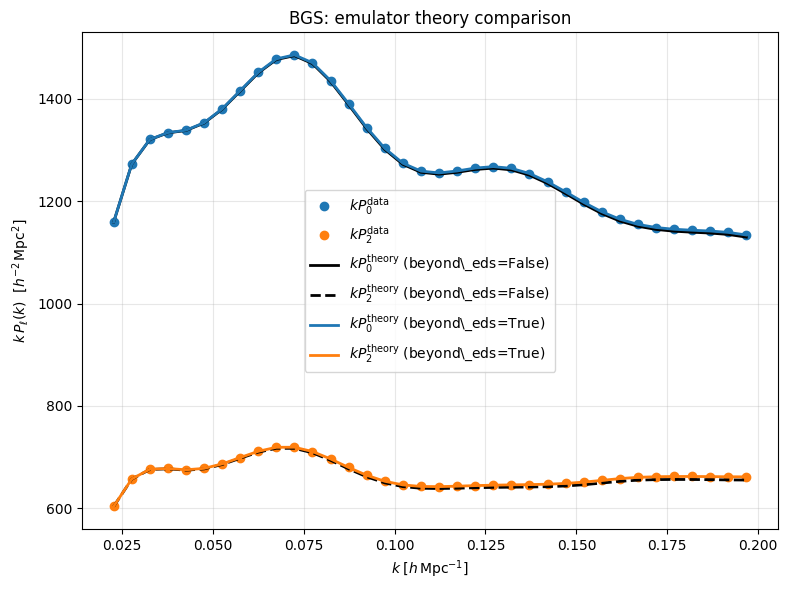

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI
from desilike.emulators import EmulatedCalculator

# =====================================================
# USER SETTINGS
# =====================================================
workdir = Path("/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike")
emu_dir = Path("/n/netscratch/eisenstein_lab/Lab/cristhian/desilike/Emulators")

file_tag   = "BGS"
fid_model  = "LCDM"
MG_model   = "HDKI"
mg_variant = "mu_OmDE"
ells       = (0, 2)
freedom    = "min"

redshift_bins  = False
scale_bins     = False
kc             = 0.01
scale_bins_method = "traditional"

# =====================================================
# Load DATA
# =====================================================
k = np.loadtxt(workdir / f"{file_tag}_{fid_model}_k.txt")
Pvec = np.loadtxt(workdir / f"{file_tag}_{fid_model}_P0P2P4.txt")

N = len(k)
P0, P2, P4 = Pvec[:N], Pvec[N:2*N], Pvec[2*N:3*N]

# =====================================================
# BASIC COSMOLOGY
# =====================================================
z_eff = 0.295 if file_tag == "BGS" else 1.492

h = 0.6736
ombh2 = 0.02237
omch2 = 0.12
omnuh2 = 0.06 / 93.14
As = 2.083e-09
ns = 0.9649
Neff = 3.046

# =====================================================
# BIASES
# =====================================================
mu0 = 0.0
b1 = 1.5
b2 = -0.5247206065
bs2  = 0.0
b3nl = 0.0
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0
ctilde, alpha0shot, alpha2shot = 0.0, 0.08, -2.0
pshotp = 10000

# =====================================================
# FUNCTION: Build theory + emulator for beyond_eds = flag
# =====================================================
def build_theory(beyond_eds_flag):

    cosmo = Cosmoprimo(
        engine='isitgr',
        MG_parameterization="muSigma",
        N_eff=Neff,
        m_ncdm=[0.06]
    )

    cosmo.init.params['mu0'] = dict(prior=dict(dist='uniform', limits=[-5., 5.]))
    cosmo.init.params['mu0'].update(value=mu0)

    cosmo_params = {
        "h": h,
        "omega_b": ombh2,
        "omega_cdm": omch2,
        "logA": np.log(1e10 * As),
        "n_s": ns,
    }
    for name, value in cosmo_params.items():
        cosmo.init.params[name].update(value=value)

    template = DirectPowerSpectrumTemplate(z=z_eff, fiducial=DESI(), cosmo=cosmo)

    theory = fkptTracerPowerSpectrumMultipoles()
    theory.init.update(
        freedom=freedom,
        prior_basis="standard",
        tracer=file_tag,
        template=template,
        k=k,
        ells=list(ells),
        model=MG_model,
        mg_variant=mg_variant,
        beyond_eds=beyond_eds_flag,
        rescale_PS=False,
        shotnoise=pshotp
    )

    # Fix biases
    for name, val in zip(
        ['b1','b2','bs2','b3nl','alpha0','alpha2','alpha4','ctilde','alpha0shot','alpha2shot'],
        [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot]
    ):
        theory.init.params[name].update(fixed=True, value=val)

    # --------------------------------------------------
    # Load correct emulator backend
    # --------------------------------------------------
    #def emu_filename(tag, k, ells, beyond_eds, redshift_bins, scale_bins, kc, scale_bins_method):
    #    dk = float(np.median(np.diff(k)))
    #    kmin_edge = float(k.min() - 0.5 * dk)
    #    kmax_edge = float(k.max() + 0.5 * dk)
    #    if redshift_bins and scale_bins:
    #        mode = f"binning_zk-{scale_bins_method}_with_kc_{kc:g}"
    #    elif redshift_bins:
    #        mode = "binning_z"
    #    else:
    #        mode = "mu0"
    #    if not beyond_eds:
    #        mode = "eds_" + mode
    #    return f"emu-fs_fkpt_isitgr_{mode}_{tag}_k{kmin_edge:.3f}-{kmax_edge:.3f}_l02.npy"
#
    #emu_path = emu_dir / emu_filename(file_tag, k, ells, beyond_eds_flag, redshift_bins, scale_bins, kc, scale_bins_method)
    #print(emu_path)
    #emu = EmulatedCalculator.load(str(emu_path))
    #theory.init.update(pt=emu)

    return theory


# =====================================================
# Evaluate both theories
# =====================================================
theory_false = build_theory(False)
theory_true  = build_theory(True)

Pth_false = np.asarray(theory_false(mu0=0.))
Pth_true  = np.asarray(theory_true(mu0=0.))

# Helper to unpack theory vector
def unpack(P):
    if P.ndim == 1:
        Ncut = len(k)
        return P[:Ncut], P[Ncut:2*Ncut], P[2*Ncut:3*Ncut]
    elif P.ndim == 2:
        return P[0], P[1], 0*k
    else:
        raise ValueError

P0_f, P2_f, P4_f = unpack(Pth_false)
P0_t, P2_t, P4_t = unpack(Pth_true)

# =====================================================
# PLOT
# =====================================================
plt.figure(figsize=(8,6))

# ---- DATA ----
plt.plot(k, k*P0, 'o', color='C0', label=r'$kP_0^\mathrm{data}$')
plt.plot(k, k*P2, 'o', color='C1', label=r'$kP_2^\mathrm{data}$')

# ---- beyond_eds = False (always BLACK) ----
plt.plot(k, k*P0_f, '-', color='black', lw=2,
         label=r'$kP_0^\mathrm{theory}$ (beyond\_eds=False)')
plt.plot(k, k*P2_f, '--', color='black', lw=2,
         label=r'$kP_2^\mathrm{theory}$ (beyond\_eds=False)')

# ---- beyond_eds = True (colored) ----
plt.plot(k, k*P0_t, '-', color='C0', lw=2,
         label=r'$kP_0^\mathrm{theory}$ (beyond\_eds=True)')
plt.plot(k, k*P2_t, '-', color='C1', lw=2,
         label=r'$kP_2^\mathrm{theory}$ (beyond\_eds=True)')

plt.xlabel(r"$k \; [h\,\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$k\,P_\ell(k)$  [$h^{-2}\,\mathrm{Mpc}^2$]")
plt.title(f"{file_tag}: emulator theory comparison")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Toy plot for effect of beyond-EdS kernel effect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI
from desilike.emulators import EmulatedCalculator

# =====================================================
# USER SETTINGS
# =====================================================
workdir = Path("/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike")
emu_dir = Path("/n/netscratch/eisenstein_lab/Lab/cristhian/desilike/Emulators")

file_tag   = "BGS"
fid_model  = "LCDM"
MG_model   = "HDKI"
mg_variant = "BZ"
ells       = (0, 2)
freedom    = "max"

redshift_bins  = False
scale_bins     = False
kc             = 0.01
scale_bins_method = "traditional"

# =====================================================
# Load DATA
# =====================================================
k = np.loadtxt(workdir / f"{file_tag}_{fid_model}_k.txt")
Pvec = np.loadtxt(workdir / f"{file_tag}_{fid_model}_P0P2P4.txt")

N = len(k)
P0, P2, P4 = Pvec[:N], Pvec[N:2*N], Pvec[2*N:3*N]

# =====================================================
# BASIC COSMOLOGY
# =====================================================
z_eff = 0.295 if file_tag == "BGS" else 1.492

h = 0.6736
ombh2 = 0.02237
omch2 = 0.12
omnuh2 = 0.06 / 93.14
As = 2.083e-09
ns = 0.9649
Neff = 3.046

# =====================================================
# BIASES
# =====================================================
mu0 = 0.0
b1 = 1.5
b2 = -0.5247206065
bs2  = 0.0
b3nl = 0.0
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0
ctilde, alpha0shot, alpha2shot = 0.0, 0.08, -2.0
pshotp = 10000

# =====================================================
# FUNCTION: Build theory + emulator for beyond_eds = flag
# =====================================================
def build_theory(beyond_eds_flag):

    cosmo = Cosmoprimo(
        engine='isitgr',
        MG_parameterization="mueta",
        N_eff=Neff,
        m_ncdm=[0.06]
    )

#    cosmo.init.params['mu0'] = dict(prior=dict(dist='uniform', limits=[-5., 5.]))
#    cosmo.init.params['mu0'].update(value=mu0)

    cosmo_params = {
        "h": h,
        "omega_b": ombh2,
        "omega_cdm": omch2,
        "logA": np.log(1e10 * As),
        "n_s": ns,
    }
    for name, value in cosmo_params.items():
        cosmo.init.params[name].update(value=value)

    template = DirectPowerSpectrumTemplate(z=z_eff, fiducial=DESI(), cosmo=cosmo)

    theory = fkptTracerPowerSpectrumMultipoles()
    theory.init.update(
        freedom=freedom,
        prior_basis="standard",
        tracer=file_tag,
        template=template,
        k=k,
        ells=list(ells),
        model=MG_model,
        mg_variant=mg_variant,
        beyond_eds=beyond_eds_flag,
        rescale_PS=False,
        shotnoise=pshotp
    )

    # Fix biases
    for name, val in zip(
        ['b1','b2','bs2','b3nl','alpha0','alpha2','alpha4','ctilde','alpha0shot','alpha2shot'],
        [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot]
    ):
        theory.init.params[name].update(fixed=True, value=val)

    # --------------------------------------------------
    # Load correct emulator backend
    # --------------------------------------------------
    #def emu_filename(tag, k, ells, beyond_eds, redshift_bins, scale_bins, kc, scale_bins_method):
    #    dk = float(np.median(np.diff(k)))
    #    kmin_edge = float(k.min() - 0.5 * dk)
    #    kmax_edge = float(k.max() + 0.5 * dk)
    #    if redshift_bins and scale_bins:
    #        mode = f"binning_zk-{scale_bins_method}_with_kc_{kc:g}"
    #    elif redshift_bins:
    #        mode = "binning_z"
    #    else:
    #        mode = "mu0"
    #    if not beyond_eds:
    #        mode = "eds_" + mode
    #    return f"emu-fs_fkpt_isitgr_{mode}_{tag}_k{kmin_edge:.3f}-{kmax_edge:.3f}_l02.npy"
#
    #emu_path = emu_dir / emu_filename(file_tag, k, ells, beyond_eds_flag, redshift_bins, scale_bins, kc, scale_bins_method)
    #print(emu_path)
    #emu = EmulatedCalculator.load(str(emu_path))
    #theory.init.update(pt=emu)

    return theory


# =====================================================
# Evaluate both theories
# =====================================================
theory_false = build_theory(False)
theory_true  = build_theory(True)

Pth_false = np.asarray(theory_false())
Pth_true  = np.asarray(theory_true())

# Helper to unpack theory vector
def unpack(P):
    if P.ndim == 1:
        Ncut = len(k)
        return P[:Ncut], P[Ncut:2*Ncut], P[2*Ncut:3*Ncut]
    elif P.ndim == 2:
        return P[0], P[1], 0*k
    else:
        raise ValueError

P0_f, P2_f, P4_f = unpack(Pth_false)
P0_t, P2_t, P4_t = unpack(Pth_true)

# =====================================================
# PLOT
# =====================================================
plt.figure(figsize=(8,6))

# ---- DATA ----
plt.plot(k, k*P0, 'o', color='C0', label=r'$kP_0^\mathrm{data}$')
plt.plot(k, k*P2, 'o', color='C1', label=r'$kP_2^\mathrm{data}$')

# ---- beyond_eds = False (always BLACK) ----
plt.plot(k, k*P0_f, '-', color='black', lw=2,
         label=r'$kP_0^\mathrm{theory}$ (beyond\_eds=False)')
plt.plot(k, k*P2_f, '--', color='black', lw=2,
         label=r'$kP_2^\mathrm{theory}$ (beyond\_eds=False)')

# ---- beyond_eds = True (colored) ----
plt.plot(k, k*P0_t, '-', color='C0', lw=2,
         label=r'$kP_0^\mathrm{theory}$ (beyond\_eds=True)')
plt.plot(k, k*P2_t, '-', color='C1', lw=2,
         label=r'$kP_2^\mathrm{theory}$ (beyond\_eds=True)')

plt.xlabel(r"$k \; [h\,\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$k\,P_\ell(k)$  [$h^{-2}\,\mathrm{Mpc}^2$]")
plt.title(f"{file_tag}: emulator theory comparison")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[first pass] mu0 = 0.000 (1/15)


/n/home12/cgarciaquintero/.conda/envs/cosmodesi/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[first pass] mu0 = 0.036 (2/15)
[first pass] mu0 = 0.071 (3/15)
[first pass] mu0 = 0.107 (4/15)
[first pass] mu0 = 0.143 (5/15)
[first pass] mu0 = 0.179 (6/15)
[first pass] mu0 = 0.214 (7/15)
[first pass] mu0 = 0.250 (8/15)
[first pass] mu0 = 0.286 (9/15)
[first pass] mu0 = 0.321 (10/15)
[first pass] mu0 = 0.357 (11/15)
[first pass] mu0 = 0.393 (12/15)
[first pass] mu0 = 0.429 (13/15)
[first pass] mu0 = 0.464 (14/15)
[first pass] mu0 = 0.500 (15/15)
[second pass] mu0 = 0.000 (1/15)
[second pass] mu0 = 0.036 (2/15)
[second pass] mu0 = 0.071 (3/15)
[second pass] mu0 = 0.107 (4/15)
[second pass] mu0 = 0.143 (5/15)
[second pass] mu0 = 0.179 (6/15)
[second pass] mu0 = 0.214 (7/15)
[second pass] mu0 = 0.250 (8/15)
[second pass] mu0 = 0.286 (9/15)
[second pass] mu0 = 0.321 (10/15)
[second pass] mu0 = 0.357 (11/15)
[second pass] mu0 = 0.393 (12/15)
[second pass] mu0 = 0.429 (13/15)
[second pass] mu0 = 0.464 (14/15)
[second pass] mu0 = 0.500 (15/15)


/tmp/ipykernel_1839019/1940999592.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.96])


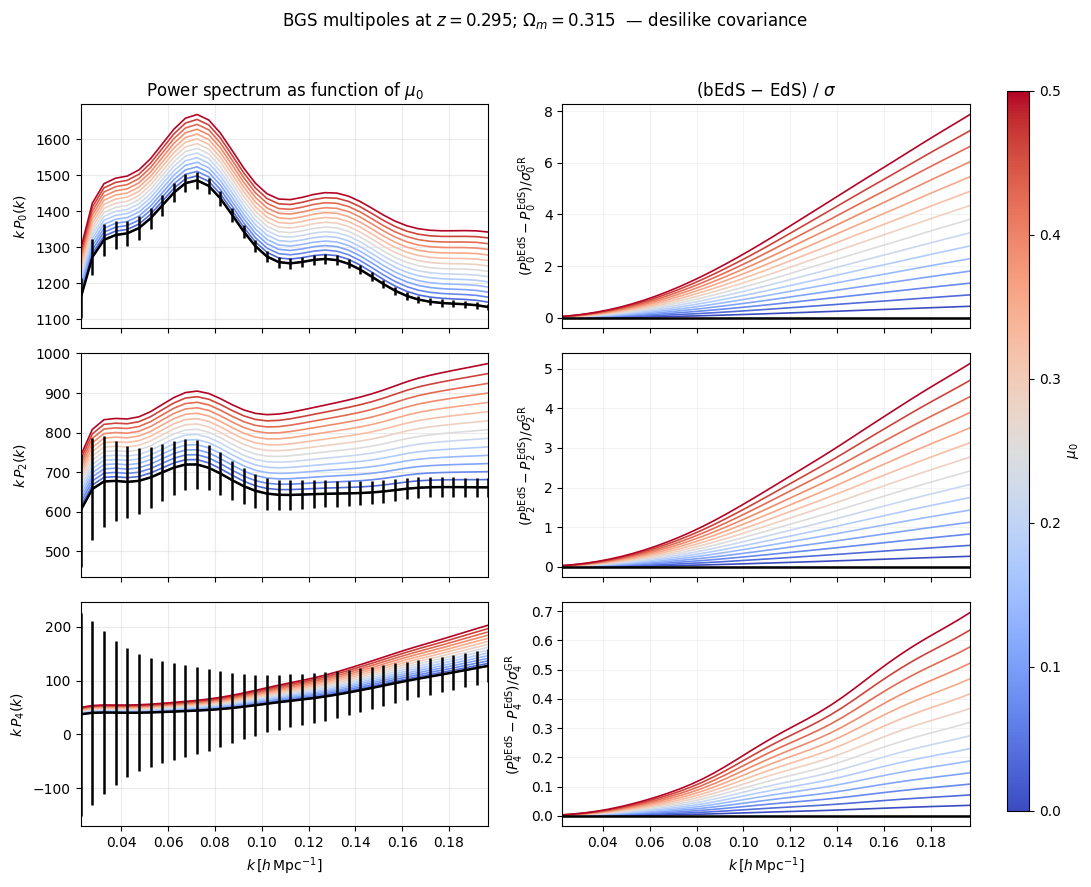

Saved figure to: /n/home12/cgarciaquintero/bEdS_vs_EdS.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

from desilike.theories import Cosmoprimo
from desilike.theories.galaxy_clustering import (
    DirectPowerSpectrumTemplate,
    fkptTracerPowerSpectrumMultipoles,
)
from cosmoprimo.fiducial import DESI

# ====================================================
# USER SETTINGS
# ====================================================
workdir = Path("/n/home12/cgarciaquintero/DESI/MG_validation/fR_noiseless_desilike")

file_tag   = "BGS"
fid_model  = "LCDM"
MG_model   = "HDKI"
mg_variant = "mu_OmDE"
ells       = (0, 2, 4)
freedom    = "max"

# k-range used for "covariance mask"
KMIN_MASK = 0.01
KMAX_MASK = 0.20

# μ0 sweep (include GR=0)
mu0_vals = np.linspace(0.0, 0.5, 15)
# For quick testing, you can temporarily do:
# mu0_vals = np.linspace(0.0, 0.5, 5)

# ====================================================
# Load data vector and covariance
# ====================================================
k = np.loadtxt(workdir / f"{file_tag}_{fid_model}_k.txt")
Pvec = np.loadtxt(workdir / f"{file_tag}_{fid_model}_P0P2P4.txt")

N = len(k)
P0_data, P2_data, P4_data = Pvec[:N], Pvec[N:2*N], Pvec[2*N:3*N]

cov_path = workdir / f"{file_tag}_{fid_model}_cov.txt"
Cov = np.loadtxt(cov_path)

# diagonal errors assuming ordering (P0, P2, P4)
diag_full = np.sqrt(np.diag(Cov))
sigma0_full = diag_full[0:N]
sigma2_full = diag_full[N:2*N]
sigma4_full = diag_full[2*N:3*N]

# ====================================================
# Cosmology + template base
# ====================================================
z_eff = 0.295

h      = 0.6736
ombh2  = 0.02237
omch2  = 0.12
omnuh2 = 0.06 / 93.14
Om     = (ombh2 + omch2 + omnuh2) / (h**2)
As     = 2.083e-09
ns     = 0.9649
Neff   = 3.046

# Nuisance parameters (fixed)
b1 = 1.5
b2 = -0.5247206065
bs2 = 0.0
b3nl = 0.0
alpha0, alpha2, alpha4 = 3.0, -1.0, 0.0
ctilde, alpha0shot, alpha2shot = 0.0, 0.08, -2.0
pshotp = 10000.0

# Build cosmology object once; we'll just update mu0
cosmo = Cosmoprimo(engine='isitgr', MG_parameterization="muSigma",
                   N_eff=Neff, m_ncdm=[0.06])

# set priors / initial values for cosmological params
cosmo.init.params['mu0'] = dict(prior=dict(dist='uniform', limits=[-5., 5.]), value=0.0)

cosmo_params = {
    "h": h,
    "omega_b": ombh2,
    "omega_cdm": omch2,
    "logA": np.log(1e10 * As),
    "n_s": ns,
}
for name, value in cosmo_params.items():
    cosmo.init.params[name].update(value=value)


def build_theory(mu0, beyond_eds_flag):
    """
    Evaluate fkptTracerPowerSpectrumMultipoles for a given mu0 and beyond_eds flag.
    Returns P0, P2, P4 on the global k-grid.
    """
    # update mu0 value
    cosmo.init.params['mu0'].update(value=mu0)

    # fresh template with the updated cosmology
    template = DirectPowerSpectrumTemplate(z=z_eff, fiducial=DESI(), cosmo=cosmo)

    theory = fkptTracerPowerSpectrumMultipoles()
    theory.init.update(
        freedom=freedom,
        prior_basis="standard",
        tracer=file_tag,
        template=template,
        k=k,
        ells=list(ells),
        model=MG_model,
        mg_variant=mg_variant,
        beyond_eds=beyond_eds_flag,
        rescale_PS=False,
        shotnoise=pshotp
    )

    # Fix nuisance parameters
    for name, val in zip(
        ["b1","b2","bs2","b3nl","alpha0","alpha2","alpha4","ctilde",
         "alpha0shot","alpha2shot"],
        [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde,
         alpha0shot, alpha2shot]
    ):
        theory.init.params[name].update(fixed=True, value=val)

    # Evaluate theory
    P_theory = np.asarray(theory())
    if P_theory.ndim == 1:
        P0, P2, P4 = P_theory[:N], P_theory[N:2*N], P_theory[2*N:3*N]
    elif P_theory.ndim == 2:
        P0, P2, P4 = P_theory[0], P_theory[1], P_theory[2]
    else:
        raise ValueError("Unexpected dimensionality for P_theory")

    return P0, P2, P4


def compute_multipoles_pair(mu0):
    """
    Analogue of your pyfkpt compute_multipoles_pair(mu0), but using desilike/fkpt:
    returns k, (P0E, P2E, P4E), (P0B, P2B, P4B).
    """
    P0E, P2E, P4E = build_theory(mu0, beyond_eds_flag=False)  # EdS
    P0B, P2B, P4B = build_theory(mu0, beyond_eds_flag=True)   # beyond-EdS
    return k, (P0E, P2E, P4E), (P0B, P2B, P4B)


# ====================================================
# 3×2 FIGURE: absolute bEdS + GR errors, and significance
# ====================================================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(11, 9), sharex='col')
(ax0_abs, ax0_sig), (ax2_abs, ax2_sig), (ax4_abs, ax4_sig) = axes

# --- color map for μ0 sweep ---
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=mu0_vals.min(), vmax=mu0_vals.max())
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.92, 0.09, 0.02, 0.80])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])

k_for_cov = None
P0E_GR = P2E_GR = P4E_GR = None
P0B_GR = P2B_GR = P4B_GR = None

# ---------- sweep over μ0 (first pass to cache GR & draw absolute curves) ----------
for i, mu0 in enumerate(mu0_vals):
    print(f"[first pass] mu0 = {mu0:.3f} ({i+1}/{len(mu0_vals)})")
    k_th, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(mu0)
    color = cmap(norm(mu0))

    if k_for_cov is None:
        k_for_cov = k_th.copy()

    if np.isclose(mu0, 0.0):
        P0E_GR, P2E_GR, P4E_GR = P0E.copy(), P2E.copy(), P4E.copy()
        P0B_GR, P2B_GR, P4B_GR = P0B.copy(), P2B.copy(), P4B.copy()

    # left column: absolute beyond-EdS k*Pℓ (colored by μ0)
    ax0_abs.plot(k_th, k_th * P0B, color=color, lw=1.2)
    ax2_abs.plot(k_th, k_th * P2B, color=color, lw=1.2)
    ax4_abs.plot(k_th, k_th * P4B, color=color, lw=1.2)

if k_for_cov is None or P0B_GR is None:
    raise RuntimeError("No GR (mu0=0) case computed; can't build covariance / significance.")

# ---------- build σ_ℓ from loaded Cov and apply k mask ----------
mask_cov = (k_for_cov > KMIN_MASK) & (k_for_cov < KMAX_MASK)

k_for_cov = k_for_cov[mask_cov]
P0B_GR = P0B_GR[mask_cov]; P2B_GR = P2B_GR[mask_cov]; P4B_GR = P4B_GR[mask_cov]
P0E_GR = P0E_GR[mask_cov]; P2E_GR = P2E_GR[mask_cov]; P4E_GR = P4E_GR[mask_cov]

sig0_GR = sigma0_full[mask_cov]
sig2_GR = sigma2_full[mask_cov]
sig4_GR = sigma4_full[mask_cov]

# ---------- overplot GR (black) with error bars on abs column ----------
ax0_abs.errorbar(k_for_cov, k_for_cov * P0B_GR,
                 yerr=k_for_cov * sig0_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax2_abs.errorbar(k_for_cov, k_for_cov * P2B_GR,
                 yerr=k_for_cov * sig2_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax4_abs.errorbar(k_for_cov, k_for_cov * P4B_GR,
                 yerr=k_for_cov * sig4_GR, fmt='-', color='k', lw=1.8, capsize=0)

# ---------- recompute sweep to plot significance in right column ----------
for i, mu0 in enumerate(mu0_vals):
    print(f"[second pass] mu0 = {mu0:.3f} ({i+1}/{len(mu0_vals)})")
    k_th, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(mu0)
    color = cmap(norm(mu0))

    # differences
    d0 = P0B - P0E
    d2 = P2B - P2E
    d4 = P4B - P4E

    # restrict to covariance mask (k_th == k)
    d0_mask = d0[mask_cov]
    d2_mask = d2[mask_cov]
    d4_mask = d4[mask_cov]

    s0 = d0_mask / sig0_GR
    s2 = d2_mask / sig2_GR
    s4 = d4_mask / sig4_GR

    ax0_sig.plot(k_for_cov, s0, color=color, lw=1.2)
    ax2_sig.plot(k_for_cov, s2, color=color, lw=1.2)
    ax4_sig.plot(k_for_cov, s4, color=color, lw=1.2)

# GR reference line (zero significance) in black
ax0_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax2_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax4_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)

# ----- styling -----
# col 0: absolute (with GR + error bars); note y is k * P_ell
for ax, lab in zip([ax0_abs, ax2_abs, ax4_abs],
                   [r"$k\,P_0(k)$", r"$k\,P_2(k)$", r"$k\,P_4(k)$"]):
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

# col 1: significance (bEdS − EdS)/σ_GR
for ax, lab in zip([ax0_sig, ax2_sig, ax4_sig],
                   [r"$(P_0^{\rm bEdS}-P_0^{\rm EdS})/\sigma_0^{\rm GR}$",
                    r"$(P_2^{\rm bEdS}-P_2^{\rm EdS})/\sigma_2^{\rm GR}$",
                    r"$(P_4^{\rm bEdS}-P_4^{\rm EdS})/\sigma_4^{\rm GR}$"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.15)
    ax.set_ylabel(lab)

# x limits & labels
for col in range(2):
    for ax in axes[:, col]:
        ax.set_xlim(k_for_cov[0], k_for_cov[-1])
for ax in axes[-1, :]:
    ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")

# titles
axes[0,0].set_title("Power spectrum as function of $\\mu_0$", fontsize=12)
axes[0,1].set_title("(bEdS − EdS) / $\\sigma$", fontsize=12)

# colorbar
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mu_0$')

fig.suptitle(fr"{file_tag} multipoles at $z={z_eff}$; $\Omega_m={Om:.3f}$  — desilike covariance", y=0.98)
plt.tight_layout(rect=[0, 0, 0.90, 0.96])

# --- save as PDF ---
outpath = "/n/home12/cgarciaquintero/bEdS_vs_EdS.pdf"
fig.savefig(outpath, bbox_inches="tight")

plt.show()
print("Saved figure to:", outpath)
